# Boston Housing

Neste projeto iremos testar modelos de Machine Learning para prever certas características de quarteirões na cidade de Boston. Um breve resumo do que foi feito neste notebook pode ser visto em um vídeo no link https://youtu.be/8pi_DYwXtUo

## 0.1 Imports

In [ ]:
import os
import json
import requests
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Estaremos coletando os dados do site https://lib.stat.cmu.edu/datasets/boston da seguinte forma:

In [ ]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
           'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

url = 'https://lib.stat.cmu.edu/datasets/boston'
response = requests.get(url)

# Convert the response to a list of lines
data_lines = response.text.split('\n')

# Find where the actual data begins
for i, line in enumerate(data_lines):
    if line.strip().startswith('0.00632'):
        start_line = i
        break

# Process the data lines
raw_data = []
current_row = []

# Process lines after the header
data_lines = data_lines[start_line:]
for line in data_lines:
    # Skip empty lines
    if not line.strip():
        continue

    # Extract all numbers from the line using regex
    numbers = re.findall(r'-?\d*\.?\d+', line)
    current_row.extend([float(num) for num in numbers])

    # If we have 14 numbers (complete row), add to raw_data and reset current_row
    if len(current_row) == 14:
        raw_data.append(current_row)
        current_row = []

df = pd.DataFrame(raw_data, columns=columns)
df.to_csv('boston_housing.csv', index=False)

## 0.2 Carregamento dos dados

In [ ]:
boston_housing = pd.read_csv("boston_housing.csv")

# 1. Descrição dos dados

Vamos aqui dar uma breve descrição do nosso conjunto de dados e uma breve descrição das variáveis (features) que constitutem o conjunto de dados:

- CRIM - taxa de crime per capita por cidade;
- ZN - proporção de zonas residenciais por lotes com mais de 25000 pés quadrados (aproximadamente 2322 metros quadrados);
- INDUS - proporção de acres utilizados com comércios e négocios não-varejo por cidade;
- CHAS - variável artificial para o Rio Charles (1 se uma área de terra faz divisa com o rio, 0 caso contrário);
- NOX - concentração de óxidos nitrícos na atmosfera (partes por milhão);
- RM - número médio de quartos por habitação;
- AGE - proporção de unidades ocupadas por seus proprietários que foram construídas até 1940;
- DIS - distâncias ponderadas de até 5 centros de empregos;
- RAD - índice de acessibilidade a vias expressas radiais;
- TAX - taxa total de impostos sobre propriedade a cada 10.000 dólares;
- PTRATIO - proporção de aluno/professor por cidade;
- B - 1000x(Bk - 0.63)² em que Bk é a proporção de negros por cidade;
- LSTAT - porcentagem da população de baixa renda;
- MEDV - valor mediano de residências ocupadas por proprietários (em $1000).

Podemos ver as primeiras cinco amostras dos dados coletados.

In [ ]:
 seed = 42
 np.random.seed(seed)
 boston_housing.sample(n = 5, random_state = seed)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
173,0.09178,0.0,4.05,0.0,0.510,6.416,84.1,2.6463,5.0,296.0,16.6,395.50,9.04,23.6
274,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53,32.4
491,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07,13.6
72,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52,22.8
452,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,20.2,385.09,17.27,16.1


## 1.1 Colunas, número de linhas, datatypes e NaNs.

In [ ]:
boston_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


A princípio, não parece ter dados faltantes nem dados em diferentes dtypes. Portanto, não há necessidade de aplicar nenhuma técnica de imputação de dados neste ponto.

# 2. Análise Exploratória dos Dados

Por conta do tamanho pequeno do dataset, escolhemos não separar um conjunto de teste - faremos somente validação dos modelos. Sendo assim, prosseguiremos com uma uma análise exploratória sobre o conjunto todo.

In [ ]:
boston_housing_1 = boston_housing.copy()
boston_housing_1.to_csv('boston_housing_1.csv')

## 2.1 Métricas Descritivas

Abaixo, seguem algumas estatísticas das nossas "features".

In [ ]:
boston_housing_1.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## 2.2 Análise univariada

Além disso também faremos um histograma de cada coluna para uma melhor visualização.

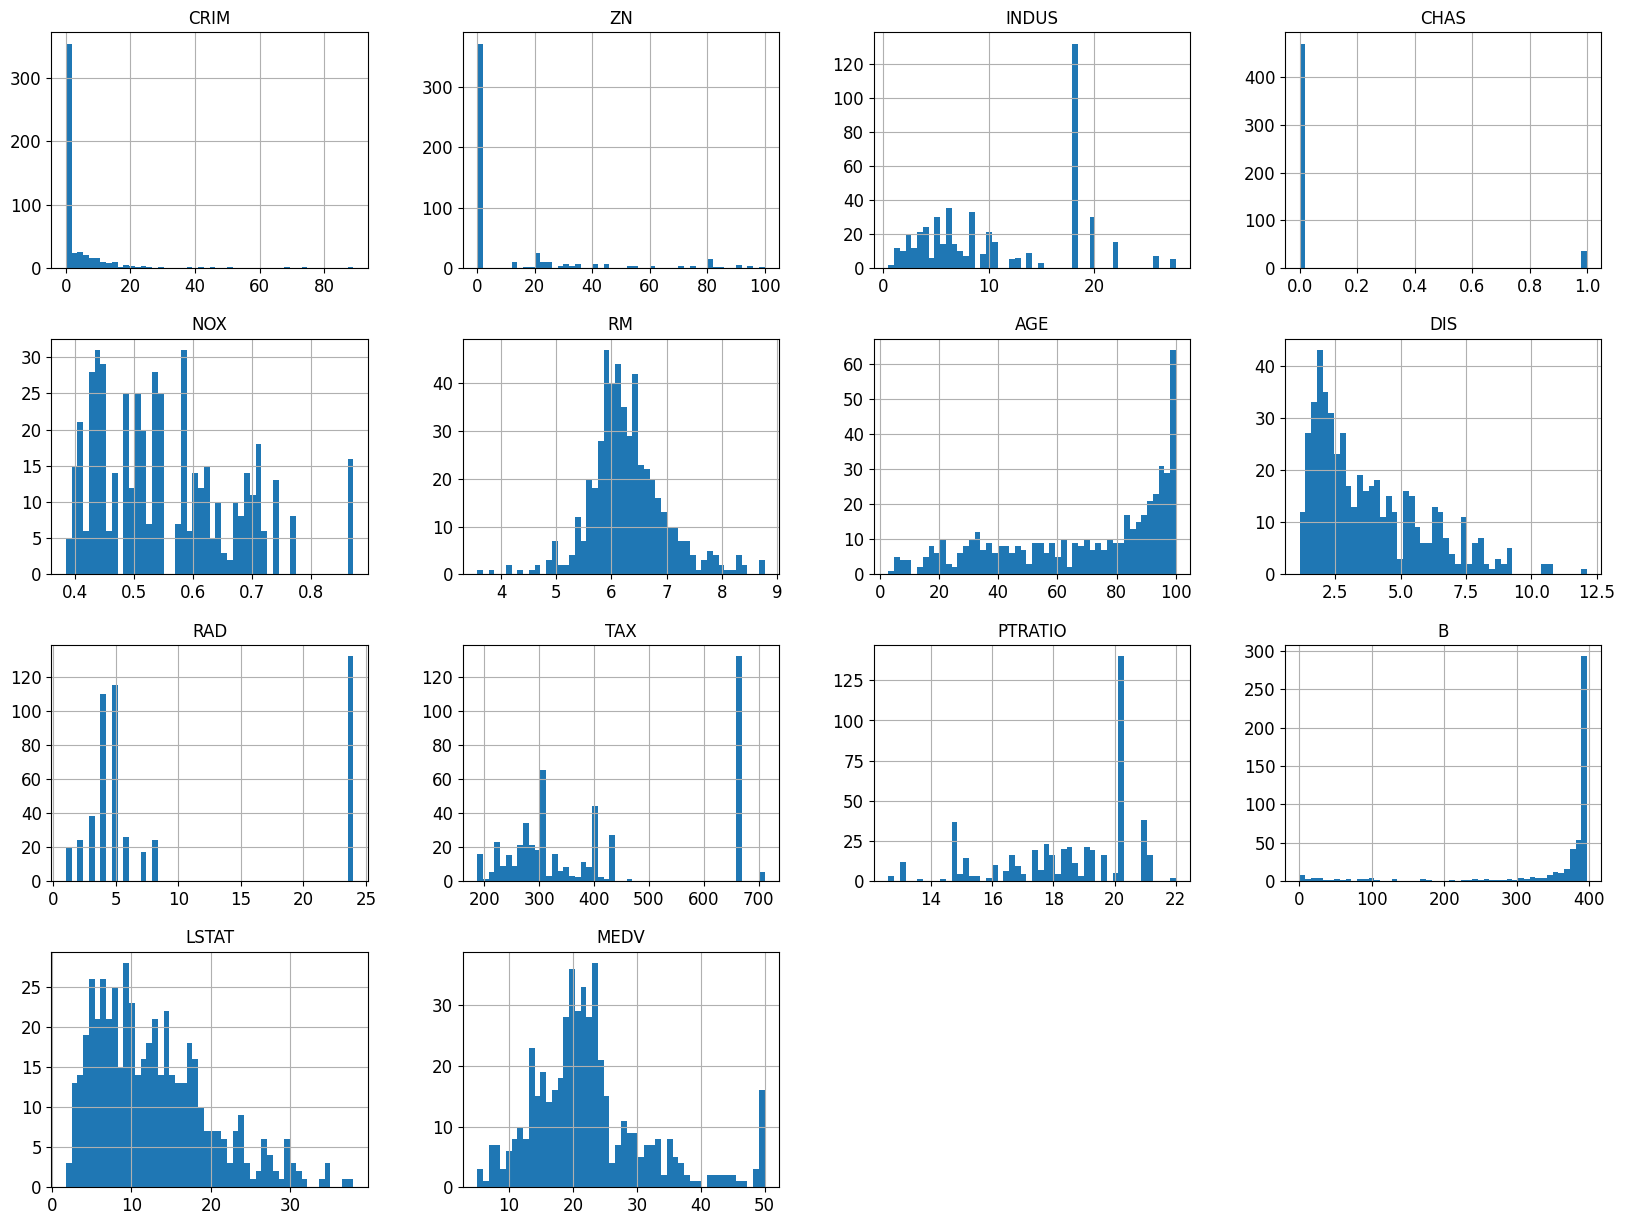

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
boston_housing_1.hist(bins=50, figsize=(20,15))
plt.show()

## 2.3 Análise de correlações

Queremos prever MEDV e NOX, então vamos plotar uma matriz de correlações e fazer a relação de MEDV e NOX com as outras features.

<Axes: >

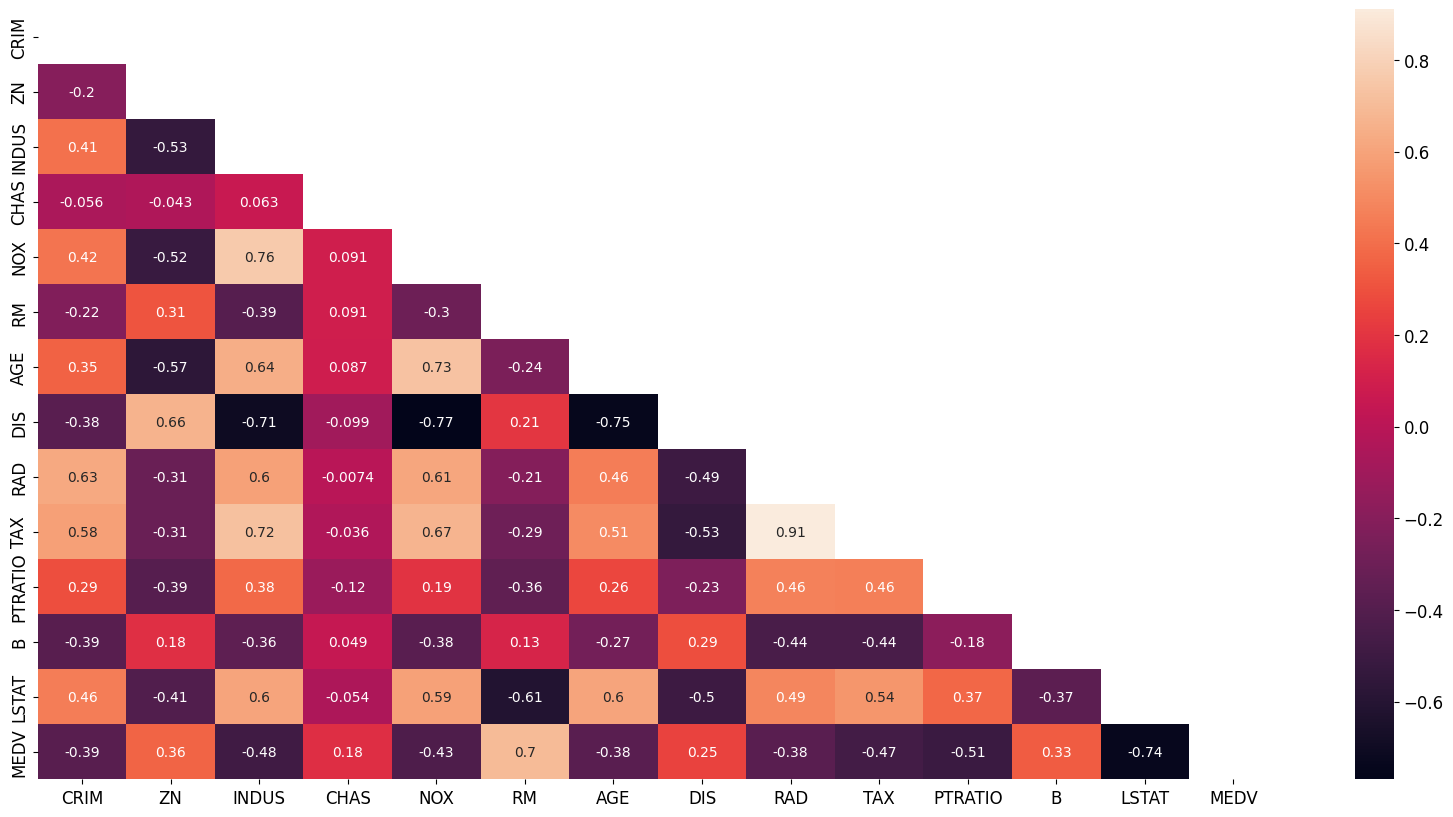

In [ ]:
corr_matrix = boston_housing_1.corr()
plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask = mask, annot=True)

Agora, seperando as colunas que queremos prever temos.

In [ ]:
corr_matrix["MEDV"].sort_values(ascending=False)

,MEDV
MEDV,1.000000
RM,0.695360
ZN,0.360445
B,0.333461
DIS,0.249929
CHAS,0.175260
AGE,-0.376955
RAD,-0.381626
CRIM,-0.388305
NOX,-0.427321


In [ ]:
corr_matrix["NOX"].sort_values(ascending=False)

,NOX
NOX,1.000000
INDUS,0.763651
AGE,0.731470
TAX,0.668023
RAD,0.611441
LSTAT,0.590879
CRIM,0.420972
PTRATIO,0.188933
CHAS,0.091203
RM,-0.302188


Disso vemos que uma das colunas que mais se relaciona com MEDV é a coluna RM, o que faz sentido, pois intuitivamente o preço de uma casa parece estar bem relacionado com o número de quartos que essa casa tem. Em relação ao NOX, comentamos que a correlação com a coluna INDUS também parece fazer sentido, pois uma grande quantidade de comércios e indústrias pode aumentar a poluição do ambiente.


## 2.4 Gráficos bivariados


Agora iremos fazer um gráfico das features com a corr>0.5 (em módulo) com MEDV e NOX.

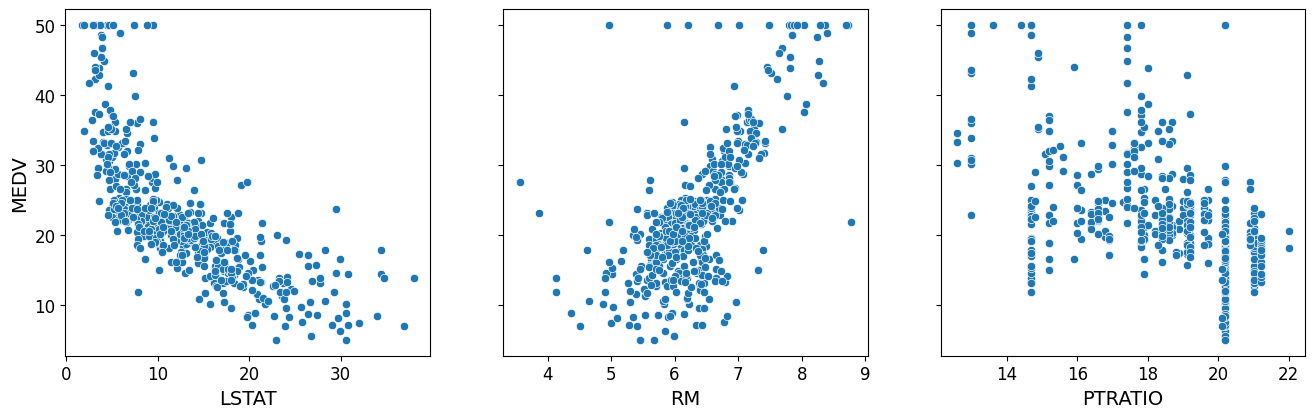

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey = 'row', figsize = (16, 4.5))

attributes = ["MEDV", "LSTAT", "RM", "PTRATIO"]

for feature, ax in zip(attributes[1:4], [ax0, ax1, ax2]):

  sns.scatterplot(data=boston_housing_1[attributes],
                  x=feature,
                  y="MEDV",
                  ax=ax)

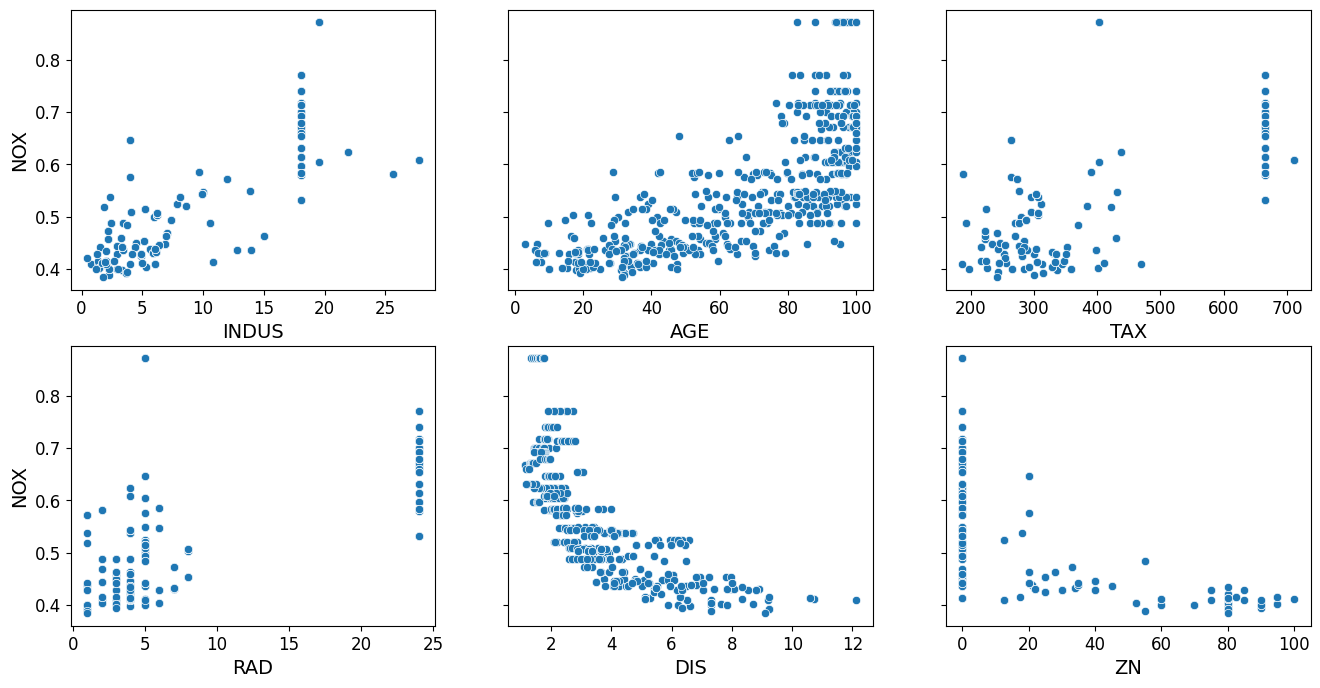

In [ ]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, sharey = 'row',figsize = (16, 8))

attributes = ["NOX", "INDUS", "AGE", "TAX", "RAD", "DIS", "ZN", "LSTAT"]

for feature, ax in zip(attributes[1:7], [ax0, ax1, ax2, ax3, ax4, ax5]):

  sns.scatterplot(data=boston_housing_1[attributes],
                  x=feature,
                  y="NOX",
                  ax=ax)

Desses gráficos, observamos um correlação linear positiva entre as features MEDV e RM, NOX e INDUS, NOX e AGE; e correlações negativas entre MEDV e LSTAT, e NOX e DIS.

# 3. Modelos

Iremos agora testar três modelos para prever as colunas NOX e MEDV, que serão: Regressão Linear, Árvore de Decisão e Random Forest.



## 3.1 Split do dataset

Neste ponto, separamos nosso dataset em conjunto de treino e conjunto de validação.

In [ ]:
train_set, test_set = train_test_split(boston_housing_1,
                                       test_size=0.2, #20% para teste
                                       random_state=seed)

## 3.2 Regressão Linear

In [ ]:
for i in ["NOX", "MEDV"]:
  reg = LinearRegression()
  reg.fit(train_set.drop(i, axis= 1), train_set[i])
  predictions = reg.predict(test_set.drop(i, axis=1))
  mse1 = MSE(test_set[i], predictions)
  rmse1 = np.sqrt(mse1) #Não é necessariamente obrigatório
  print('Erro RMSE para '+ i + ': ', format(rmse1))

Erro RMSE para NOX:  0.053897677854649086
Erro RMSE para MEDV:  4.928602182665332


O erro referente a coluna NOX é 0.05, que é um erro relativamente pequeno, e condiz com as propriedades dos dados nessa coluna, já que o desvio padrão é 0.11 e a média 0.55. Agora referente à coluna MEDV, vemos um erro de 4.92. Levando em consideração as propriedades dessa coluna, vemos que o desvio padrão é de 9.33, então quando comparado com isso talvez um erro grande não tenha tanto impacto nas previsões.

## 3.3 Árvore de Decisão

In [ ]:
for i in ["NOX", "MEDV"]:
  reg = DecisionTreeRegressor(random_state=seed)
  reg.fit(train_set.drop(i, axis= 1), train_set[i])
  predictions = reg.predict(test_set.drop(i, axis=1))
  mse1 = MSE(test_set[i], predictions)
  rmse1 = np.sqrt(mse1)
  print('Erro RMSE para '+ i + ': ', format(rmse1))

Erro RMSE para NOX:  0.032748481479538655
Erro RMSE para MEDV:  3.2273949915330395


Comparando com a Regressão Linear, vemos que obtivemos um score melhor para ambas as variáveis.

## 3.4 Random Forest

In [ ]:
for i in ["NOX", "MEDV"]:
  reg = RandomForestRegressor(random_state=seed)
  reg.fit(train_set.drop(i, axis= 1), train_set[i])
  predictions = reg.predict(test_set.drop(i, axis=1))
  mse1 = MSE(test_set[i], predictions)
  rmse1 = np.sqrt(mse1)
  print('Erro RMSE para '+ i + ': ', format(rmse1))

Erro RMSE para NOX:  0.03470886160071583
Erro RMSE para MEDV:  2.8109631609391226


Comparando com os demais, vemos que temos virtualmente o mesmo score que uma única Árvore de Decisão para a variável NOX, mas obtivemos melhora em relação a esta para a variável MEDV.

## 3.5 GridSearch sobre a Random Forest

Vamos agora tentar randomizar os hiperparâmetros da Random Forest a fim de encontrar um melhor regressor.

In [ ]:
param_grid = [{'n_estimators': [50, 100, 500], 'max_features': [5, 7, 13]}]

forest_reg = RandomForestRegressor(random_state=seed)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

for i in ["NOX", "MEDV"]:
  grid_search.fit(boston_housing_1.drop(i, axis= 1), boston_housing_1[i])
  final_model = grid_search.best_estimator_
  best_params = grid_search.best_params_
  predictions = final_model.predict(test_set.drop(i, axis=1))
  mse1 = MSE(test_set[i], predictions)
  rmse1 = np.sqrt(mse1)
  print('Melhores parâmetros para ' + i + ': ' + json.dumps(grid_search.best_params_))
  print('Erro RMSE para '+ i + ': ', format(rmse1))

Melhores parâmetros para NOX: {"max_features": 5, "n_estimators": 100}
Erro RMSE para NOX:  0.012169729499789178
Melhores parâmetros para MEDV: {"max_features": 5, "n_estimators": 50}
Erro RMSE para MEDV:  1.196207110403709


Apresentamos, por fim, dois bons candidatos à tarefa de regressão para este dataset (um para cada variável), a saber, os duas RFs com os parâmetros resultantes acima.